In [3]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

class PNGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = []
        self.labels = []
        
        for label in os.listdir(root_dir):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                for file in os.listdir(label_path):
                    if file.endswith('.png'):
                        self.files.append(os.path.join(label_path, file))
                        self.labels.append(label)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Funkcja do ładowania danych

def load_png_images(root_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),          # Konwersja do tensorów
        transforms.Normalize((0.5,), (0.5,))  # Normalizacja
    ])
    
    dataset = PNGDataset(root_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader


In [42]:
import matplotlib.pyplot as plt
import numpy as np

def plot_random_png():

    root_dir = r"C:\Users\Micha\SEM1_projects\Deep_learning_projects\project_1\data\test"
    dataloader = load_png_images(root_dir, batch_size=1)  
    data_iter = iter(dataloader)
    image, label = next(data_iter)

    image = image.squeeze(0) 
    image = image * 0.5 + 0.5  
    image = image.permute(1, 2, 0).numpy()  
    image = (image * 255).astype(np.uint8) 

    # Wyświetlenie obrazu
    plt.imshow(image)
    plt.title(f"Label: {label[0]}")
    plt.axis("off")
    plt.show()



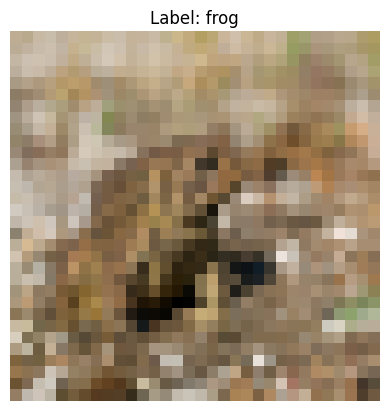

In [35]:
plot_random_png()

In [41]:
# Pobierz jeden batch z DataLoadera
root_dir = r"C:\Users\Micha\SEM1_projects\Deep_learning_projects\project_1\data\test"
dataloader = load_png_images(root_dir, batch_size=1) 
data_iter = iter(dataloader)
image, label = next(data_iter)

# Wypisz kształt tensora
print(image.shape)  
print("Zawartość tensora obrazu:")
print(image.squeeze(0).numpy()[0])  # Usunięcie wymiaru batch dla czytelności


torch.Size([1, 3, 32, 32])
Zawartość tensora obrazu:
[[-0.2235294  -0.30196077 -0.26274508 ... -0.64705884 -0.6313726
  -0.20784312]
 [-0.23921567 -0.3333333  -0.3333333  ... -0.654902   -0.62352943
  -0.5921569 ]
 [-0.11372548  0.02745104  0.05882359 ... -0.60784316 -0.4980392
  -0.60784316]
 ...
 [-0.2862745   0.5294118   0.77254903 ...  0.8352941   0.81960785
   0.70980394]
 [ 0.04313731  0.77254903  0.79607844 ...  0.8352941   0.7647059
   0.6313726 ]
 [ 0.5137255   0.8117647   0.8117647  ...  0.8039216   0.7411765
   0.6627451 ]]


In [40]:
print("Wartości piksela (0,0):", image[0, 0, :, :])


Wartości piksela (0,0): tensor([[ 0.9843,  0.9922,  0.9922,  ...,  0.9922,  0.9608,  0.9294],
        [ 1.0000,  0.9451,  0.9451,  ...,  0.9529,  0.9216,  0.3176],
        [ 0.9922,  0.6000,  0.5529,  ...,  0.5686,  0.5686, -0.1843],
        ...,
        [ 0.9608,  0.4902,  0.3882,  ...,  0.5216,  0.4588, -0.2549],
        [ 0.9216,  0.0667, -0.0275,  ...,  0.0667,  0.0275, -0.2941],
        [ 0.4588, -0.3412, -0.3333,  ..., -0.2392, -0.2941, -0.2784]])


In [52]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image

def calculate_accuracy(loader, model):
    model.eval()  # ustawienie modelu w tryb ewaluacji
    correct = 0
    total = 0
    with torch.no_grad():  # nie śledzimy gradientów podczas testowania
        for data, target in loader:
            output = model(data)
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()
    accuracy = 100 * correct / total
    return accuracy

class PNGDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.files = []
        self.labels = []
        self.label_to_idx = {}
        
        for idx, label in enumerate(os.listdir(root_dir)):
            label_path = os.path.join(root_dir, label)
            if os.path.isdir(label_path):
                self.label_to_idx[label] = idx
                for file in os.listdir(label_path):
                    if file.endswith('.png'):
                        self.files.append(os.path.join(label_path, file))
                        self.labels.append(idx)
    
    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, idx):
        img_path = self.files[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

# Funkcja do ładowania danych

def load_png_images(root_dir, batch_size=32):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    dataset = PNGDataset(root_dir, transform=transform)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    
    return dataloader, len(dataset.label_to_idx)

# Definicja prostej sieci CNN
class SimpleCNN(nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)
    
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Funkcja do trenowania modelu
def train_model(model, dataloader, num_epochs=10, learning_rate=0.001):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    
    for epoch in range(num_epochs):
        running_loss = 0.0
        for images, labels in dataloader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        
            accuracy = calculate_accuracy(dataloader, model)

            # Wyświetlanie wyników po każdej epoce
            print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(dataloader):.4f}, Accuracy: {accuracy:.2f}%")
    
    print("Training complete!")


In [53]:
# Ścieżka do katalogu z danymi (podkatalogi to etykiety)
root_dir = r"C:\Users\Micha\SEM1_projects\Deep_learning_projects\project_1\data\sample"

# Załaduj dane
dataloader, num_classes = load_png_images(root_dir, batch_size=32)

# Stwórz model
model = SimpleCNN(num_classes)

# Trenowanie modelu
train_model(model, dataloader, num_epochs=10, learning_rate=0.001)


C:\Users\Micha\AppData\Local\Temp\ipykernel_4332\2494929351.py:95: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  loss = criterion(outputs, torch.tensor(labels, dtype=torch.long))


Epoch 1/10, Loss: 0.1737, Accuracy: 60.00%
Epoch 1/10, Loss: 0.3473, Accuracy: 59.00%
Epoch 1/10, Loss: 0.5212, Accuracy: 57.00%
Epoch 1/10, Loss: 0.6887, Accuracy: 50.00%
Epoch 2/10, Loss: 0.1665, Accuracy: 50.00%
Epoch 2/10, Loss: 0.3304, Accuracy: 50.00%
Epoch 2/10, Loss: 0.5162, Accuracy: 50.00%
Epoch 2/10, Loss: 0.7026, Accuracy: 62.00%
Epoch 3/10, Loss: 0.1562, Accuracy: 63.00%
Epoch 3/10, Loss: 0.3177, Accuracy: 67.00%
Epoch 3/10, Loss: 0.4919, Accuracy: 65.00%
Epoch 3/10, Loss: 0.6684, Accuracy: 66.00%
Epoch 4/10, Loss: 0.1595, Accuracy: 63.00%
Epoch 4/10, Loss: 0.3203, Accuracy: 65.00%
Epoch 4/10, Loss: 0.4940, Accuracy: 64.00%
Epoch 4/10, Loss: 0.6486, Accuracy: 66.00%
Epoch 5/10, Loss: 0.1558, Accuracy: 62.00%
Epoch 5/10, Loss: 0.3206, Accuracy: 66.00%
Epoch 5/10, Loss: 0.4824, Accuracy: 68.00%
Epoch 5/10, Loss: 0.6542, Accuracy: 73.00%
Epoch 6/10, Loss: 0.1515, Accuracy: 68.00%
Epoch 6/10, Loss: 0.3064, Accuracy: 67.00%
Epoch 6/10, Loss: 0.4722, Accuracy: 66.00%
Epoch 6/10,